# Notebook to analyse the data on the mosaics, ground truth and results



## Imports

In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import os
import re
import sys
import time
import ants
import traceback
from shutil import copyfile
from itertools import product
from subprocess import check_call
from nibabel import load as load_nii
import nibabel as nib
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as smapi
import statsmodels.graphics as smgraphics
from scipy.stats import spearmanr, kendalltau
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage.morphology import binary_erosion as imerode
import cv2

## Evaluation functions

In [2]:
def accuracy(prediction, target):
    return 100 * np.sum(target == prediction)/len(target)


def recall(prediction, target):
    labels = np.unique(gt)
    metrics = [
        (i, 100 * np.sum(
            np.logical_and(target == i, prediction == i)) / np.sum(target == i)
        )
        for i in labels
    ]
    
    return metrics
    
    
def precision(prediction, target):
    labels = np.unique(gt)
    metrics = [
        (
            i, 100 * np.sum(np.logical_and(target == i, prediction == i)) / np.sum(prediction == i)
            if np.sum(prediction == i) > 0 else 0
        )
        for i in labels
    ]
    
    return metrics

## Mosaic analysis

In [3]:
path = './segmentation'

sites = ['S{:d}'.format(i) for i in range(1, 18)]
all_labels = []
for i in range(1, len(sites) + 1):
    gt = cv2.imread(os.path.join(path, 'S{:d}GT.png'.format(i)), cv2.IMREAD_GRAYSCALE)
    all_labels += [lab for lab in np.unique(gt).tolist() if lab not in all_labels]
    print(i, sorted(all_labels))
all_labels = sorted(all_labels)

1 [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
2 [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
3 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
4 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
5 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
6 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
7 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
8 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
9 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
10 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
11 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
12 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
13 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
14 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
17 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [4]:
areas = [0] * len(all_labels)
for i in range(1, len(sites) + 1):
    gt = cv2.imread(os.path.join(path, 'S{:d}GT.png'.format(i)), cv2.IMREAD_GRAYSCALE)
    roi = cv2.imread(os.path.join(path, 'S{:d}ROI.png'.format(i)), cv2.IMREAD_GRAYSCALE) < 100
    gt = gt[roi]
    for lab in all_labels:
        areas[lab] += np.sum(gt == lab)

for species, rate in zip(np.argsort(areas)[::-1], 100 * np.sort(areas)[::-1] / np.sum(areas)):
    print(species, rate)

0 31.83750436522643
1 16.84026622736586
3 10.627360275426897
11 8.797070326545871
9 5.7685679804855186
8 5.20428209555718
10 5.125156019371473
4 4.555921352521537
5 4.317202219306984
2 2.819511286839277
6 2.1043273585741202
7 2.0028304927788554


In [5]:
relative_areas = np.zeros((len(sites), len(all_labels)))
for i in range(1, len(sites) + 1):
    gt = cv2.imread(os.path.join(path, 'S{:d}GT.png'.format(i)), cv2.IMREAD_GRAYSCALE)
    roi = cv2.imread(os.path.join(path, 'S{:d}ROI.png'.format(i)), cv2.IMREAD_GRAYSCALE) < 100
    gt = gt[roi]
    for lab in all_labels:
        relative_areas[i - 1][lab] = 100 * np.sum(gt == lab) / areas[lab]

In [6]:
mosaic_areas = np.zeros((len(sites) + 1, len(all_labels)))
for i in range(1, len(sites) + 1):
    gt = cv2.imread(os.path.join(path, 'S{:d}GT.png'.format(i)), cv2.IMREAD_GRAYSCALE)
    roi = cv2.imread(os.path.join(path, 'S{:d}ROI.png'.format(i)), cv2.IMREAD_GRAYSCALE) < 100
    gt = gt[roi]
    for lab in all_labels:
        mosaic_areas[i - 1][lab] = 100 * np.sum(gt == lab) / len(gt)
for lab in all_labels:
    mosaic_areas[-1][lab] = 100 * areas[lab] / np.sum(areas)

<IPython.core.display.Javascript object>


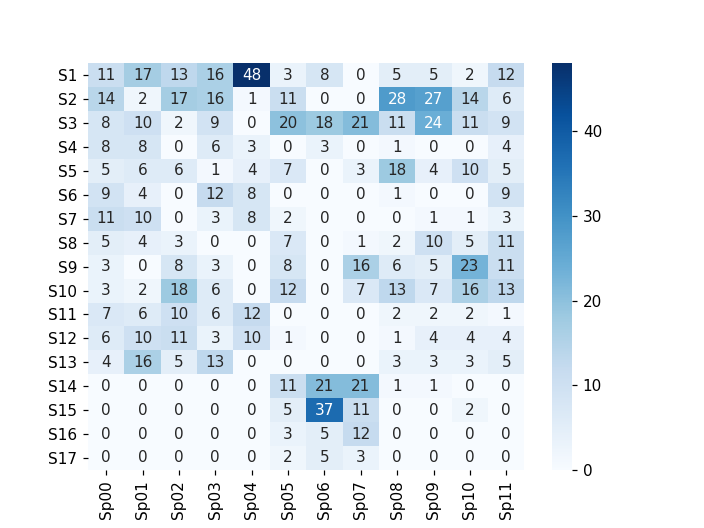

<AxesSubplot:>

In [7]:
df_relative = pd.DataFrame(
    relative_areas, index = sites,
    columns = ['Sp{:02d}'.format(k) for k in range(0, 12)]
)
plt.figure()
sn.heatmap(df_relative, annot=True, cmap='Blues')

<IPython.core.display.Javascript object>


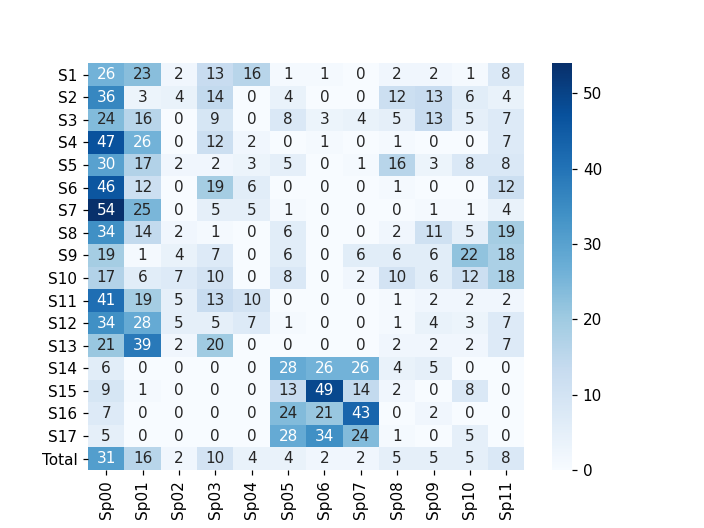

<AxesSubplot:>

In [8]:
df_mosaic = pd.DataFrame(
    mosaic_areas, index = sites  + ['Total'],
    columns = ['Sp{:02d}'.format(k) for k in range(0, 12)]
)
plt.figure()
sn.heatmap(df_mosaic, annot=True, cmap='Blues')

In [9]:
precision_matrix = np.zeros((len(sites), len(all_labels)))
recall_matrix = np.zeros((len(sites), len(all_labels)))
for i in range(1, len(sites) + 1):
    gt = cv2.imread(os.path.join(path, 'S{:d}GT.png'.format(i)), cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(os.path.join(path, 'S{:d}Result.png'.format(i)), cv2.IMREAD_GRAYSCALE)
    roi = cv2.imread(os.path.join(path, 'S{:d}ROI.png'.format(i)), cv2.IMREAD_GRAYSCALE) < 100

    gt_vec = gt[roi]
    pred_vec = pred[roi]
    
    recalls = recall(pred_vec, gt_vec)
    precisions = precision(pred_vec, gt_vec)

    for (lab, recall_i), (_, precision_i) in zip(recalls, precisions):
#         print(
#             'S{:d}'.format(i), 'Class', lab, recall_i, precision_i
#         )
        precision_matrix[i - 1][lab] = precision_i
        recall_matrix[i - 1][lab] = recall_i
        
    print('S{:d} Accuracy'.format(i), accuracy(pred_vec, gt_vec))

S1 Accuracy 58.83980120752122
S2 Accuracy 49.66544382377945
S3 Accuracy 41.482224336841014
S4 Accuracy 71.71287979742729
S5 Accuracy 46.1731961126893
S6 Accuracy 65.39388987851711
S7 Accuracy 75.86684170743676
S8 Accuracy 41.06951569934293
S9 Accuracy 24.474576423774668
S10 Accuracy 33.85601233288907
S11 Accuracy 68.59735384239677
S12 Accuracy 64.0426179249353
S13 Accuracy 79.71423066270066
S14 Accuracy 53.48360489572337
S15 Accuracy 51.52293672967217
S16 Accuracy 66.96963675089863
S17 Accuracy 32.551190994272126


<IPython.core.display.Javascript object>


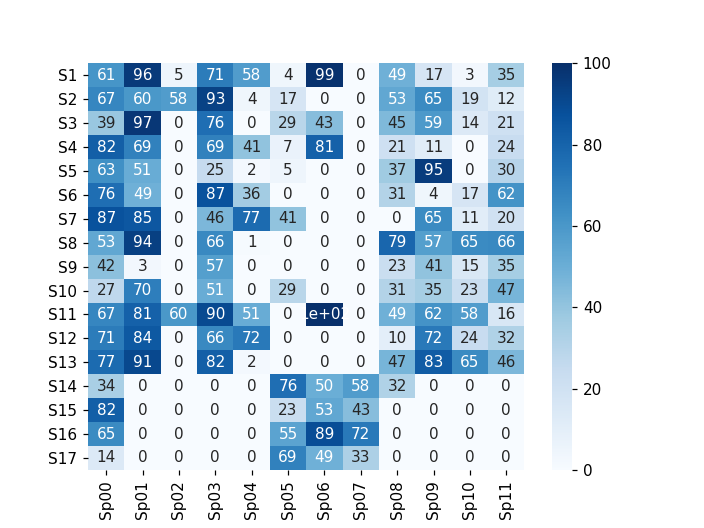

<IPython.core.display.Javascript object>


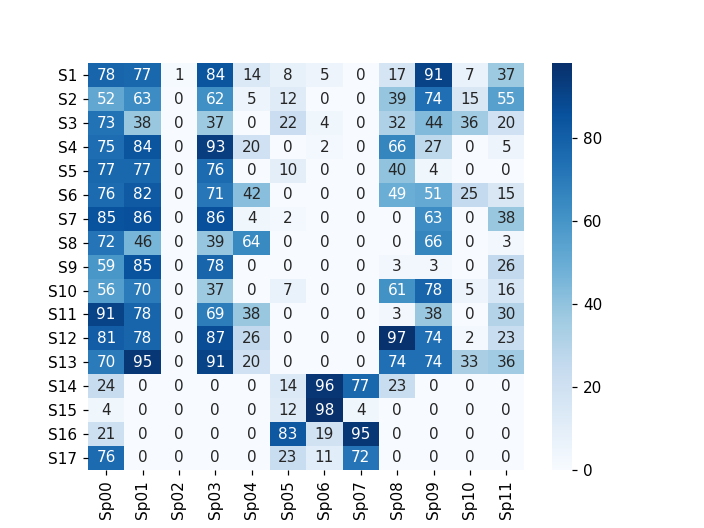

<AxesSubplot:>

In [10]:
df_precision = pd.DataFrame(
    precision_matrix, index = sites,
    columns = ['Sp{:02d}'.format(k) for k in range(0, 12)]
)
plt.figure()
sn.heatmap(df_precision, annot=True, cmap='Blues')

df_recall = pd.DataFrame(
    recall_matrix, index = sites,
    columns = ['Sp{:02d}'.format(k) for k in range(0, 12)]
)
plt.figure()
sn.heatmap(df_recall, annot=True, cmap='Blues')

1 [ 0  1  2  3  4  5  6  8  9 10 11] [ 0  1  2  3  4  5  6  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


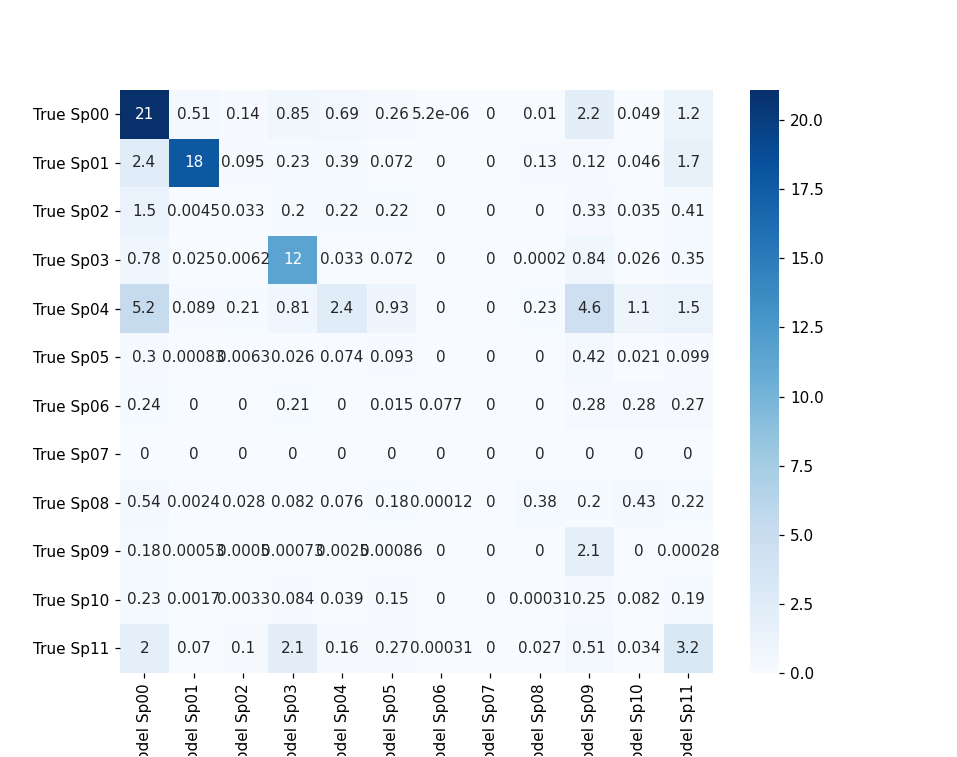

2 [ 0  1  2  3  4  5  8  9 10 11] [ 0  1  2  3  4  5  6  7  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


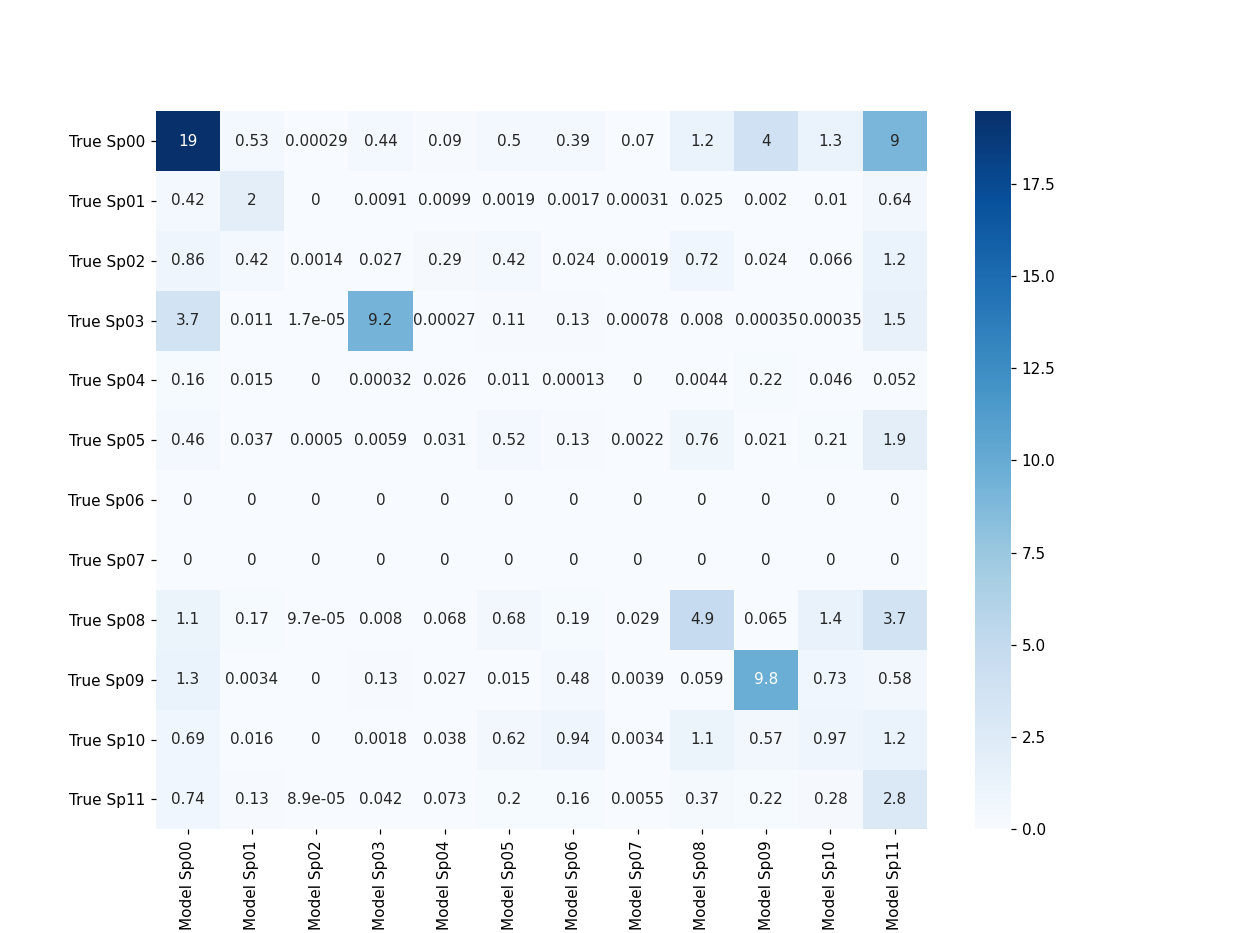

3 [ 0  1  2  3  4  5  6  7  8  9 10 11] [ 0  1  2  3  4  5  6  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


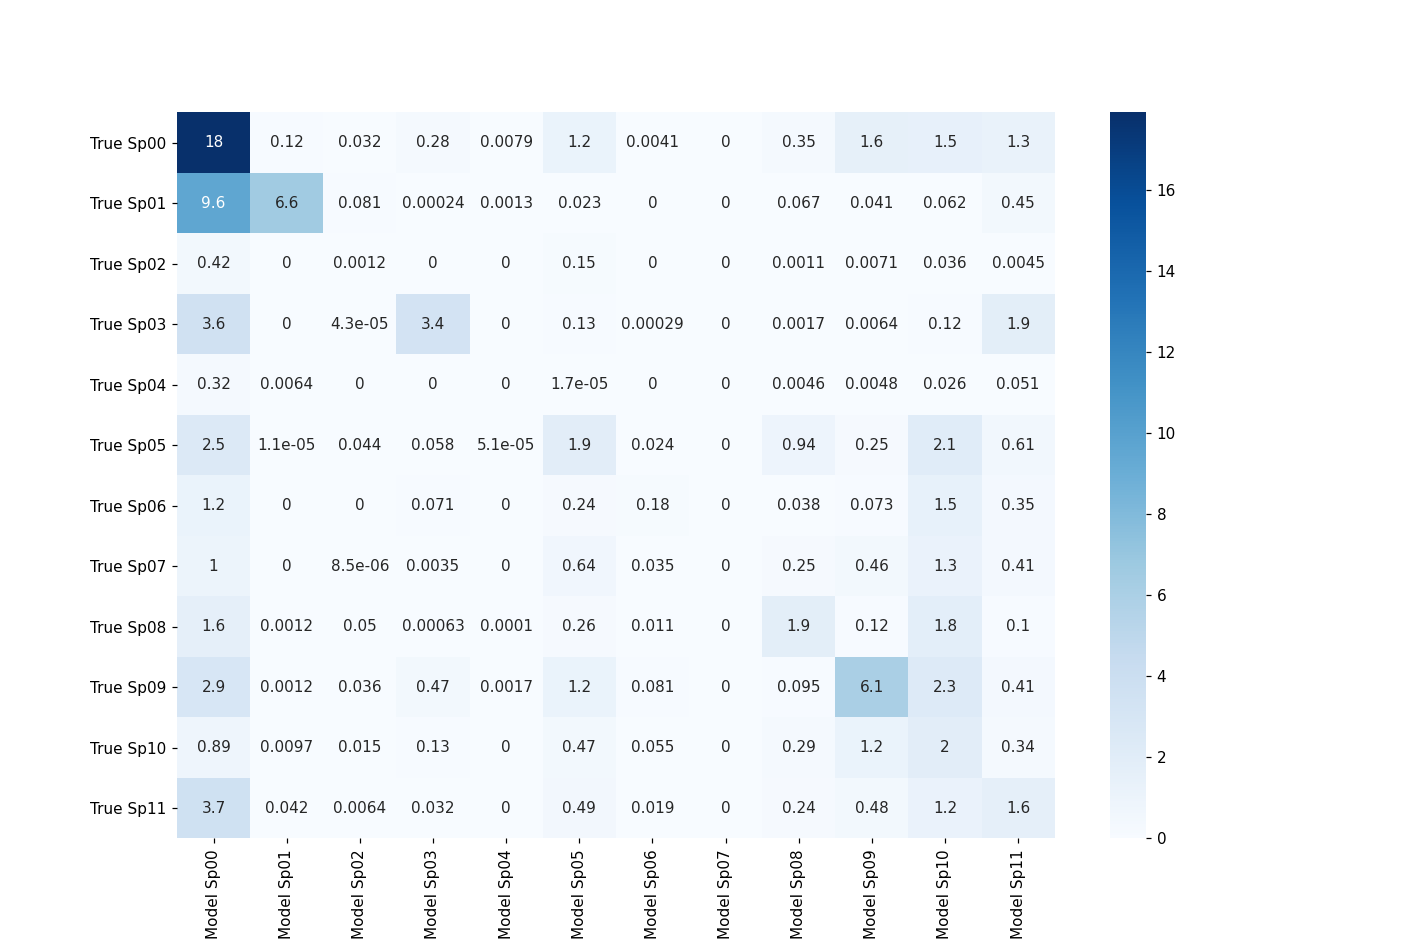

4 [ 0  1  3  4  5  6  8  9 11] [ 0  1  3  4  5  6  7  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


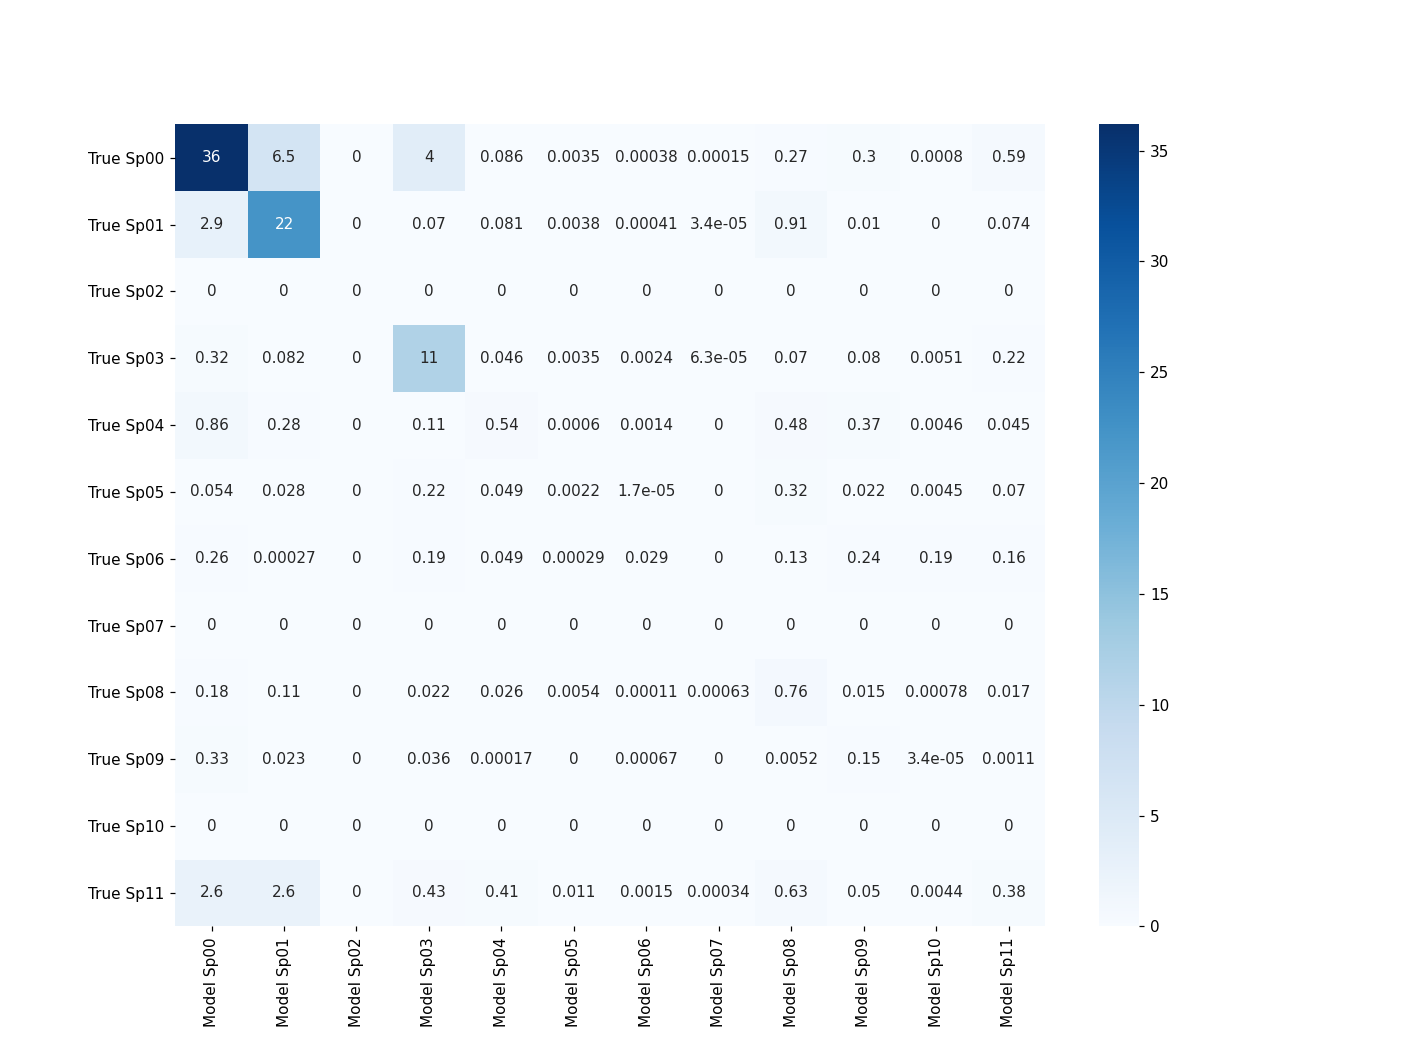

5 [ 0  1  2  3  4  5  7  8  9 10 11] [ 0  1  3  4  5  6  7  8  9 11] (12, 12)


<IPython.core.display.Javascript object>


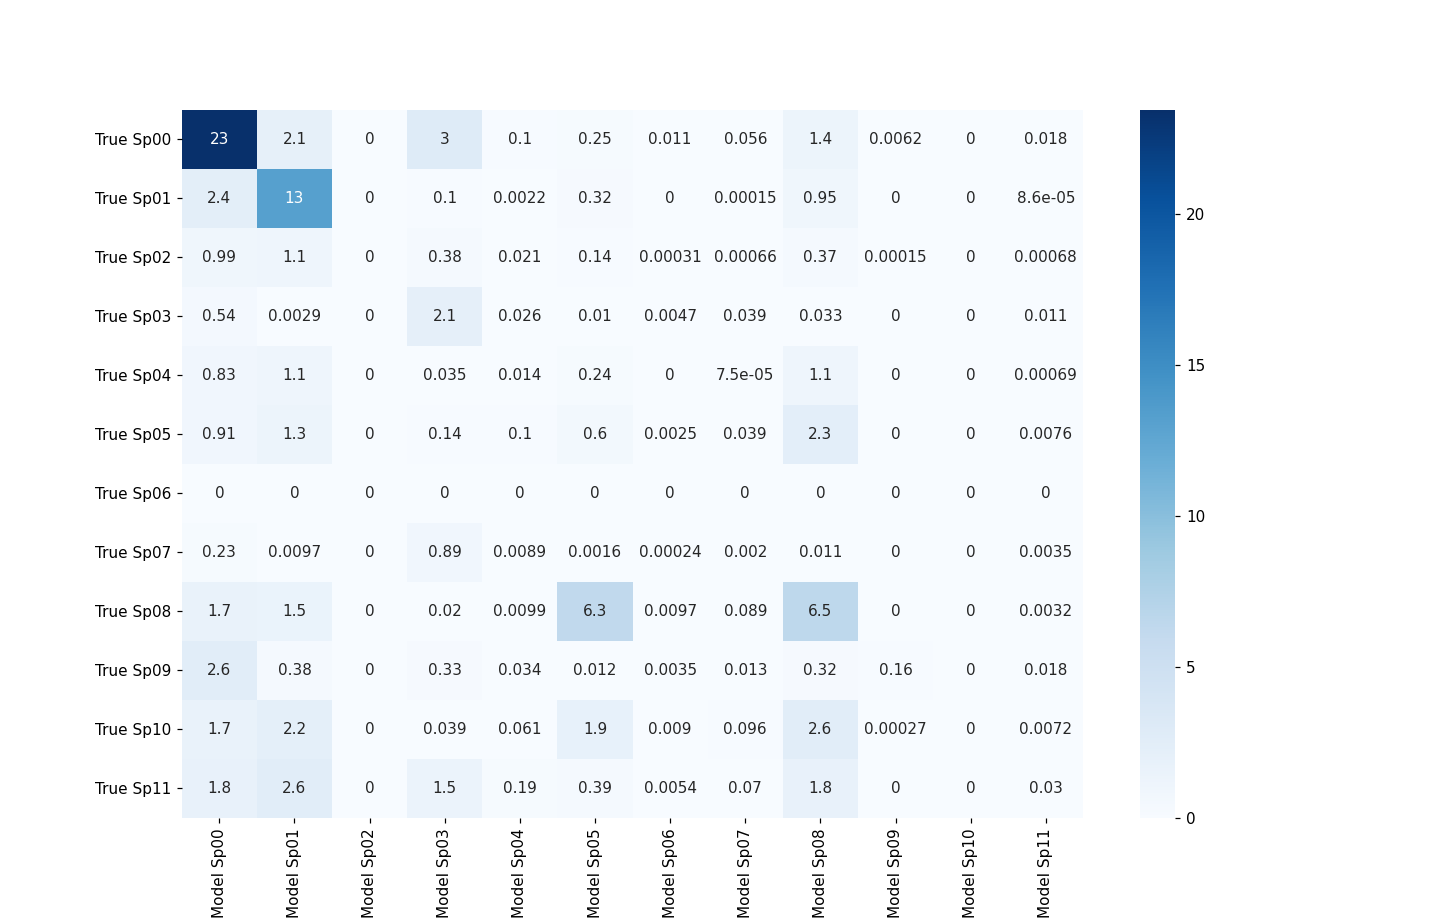

6 [ 0  1  2  3  4  5  8  9 10 11] [ 0  1  3  4  5  6  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


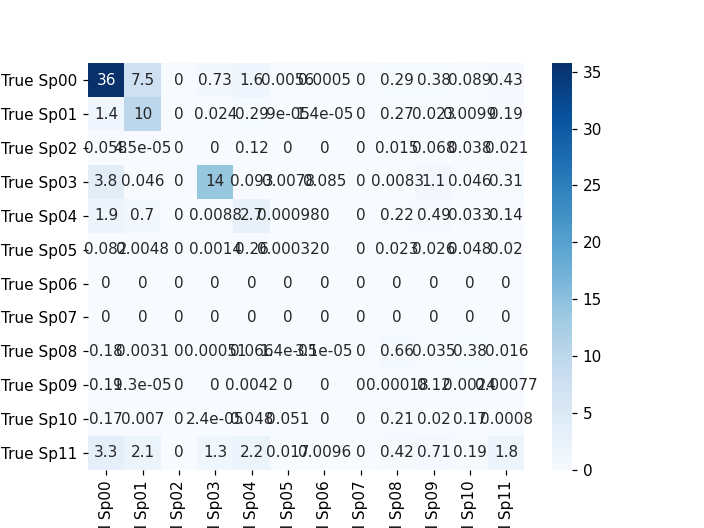

7 [ 0  1  2  3  4  5  8  9 10 11] [ 0  1  2  3  4  5  6  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


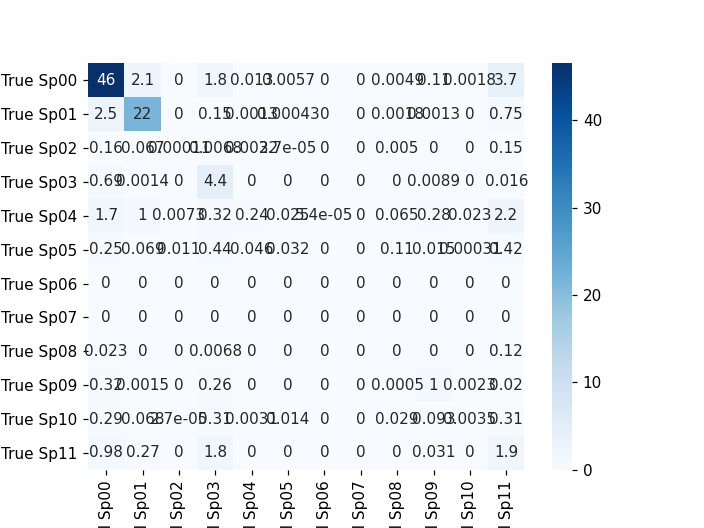

8 [ 0  1  2  3  4  5  7  8  9 10 11] [ 0  1  3  4  6  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


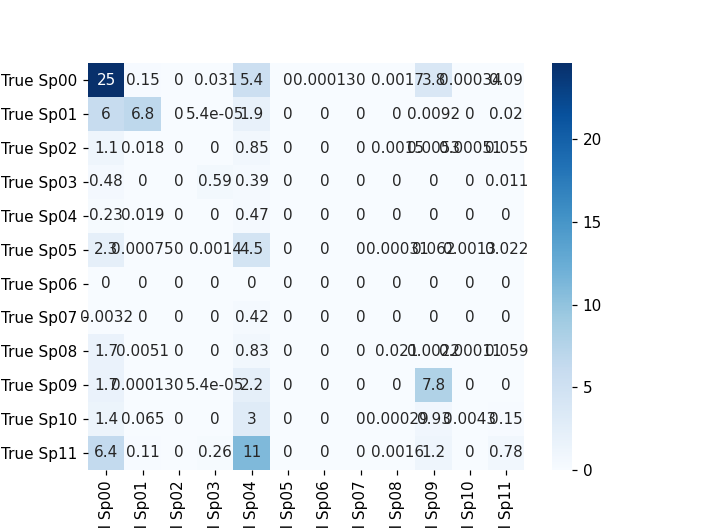

9 [ 0  1  2  3  5  7  8  9 10 11] [ 0  1  2  3  4  5  6  7  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


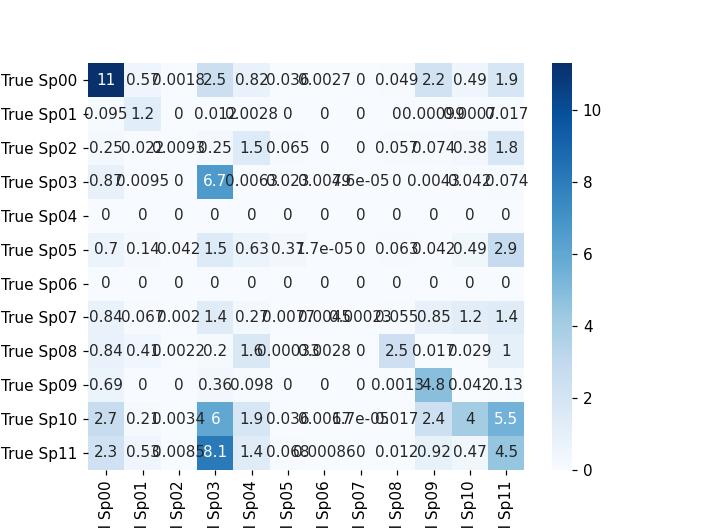

10 [ 0  1  2  3  5  7  8  9 10 11] [ 0  1  3  4  5  6  7  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


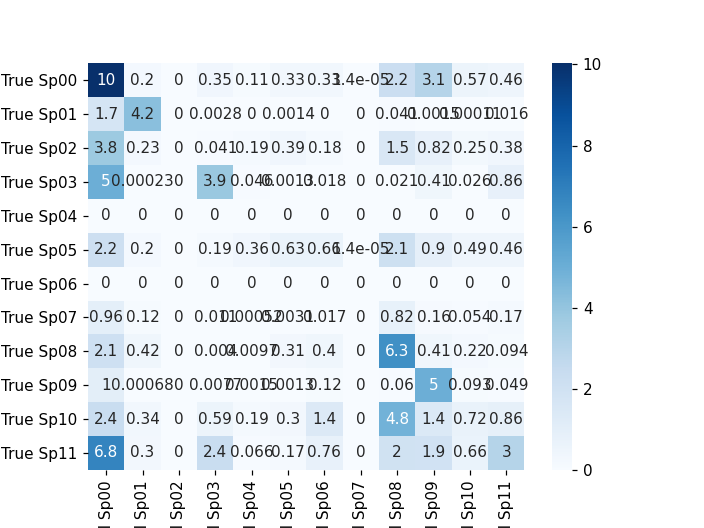

11 [ 0  1  2  3  4  6  8  9 10 11] [ 0  1  2  3  4  5  6  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


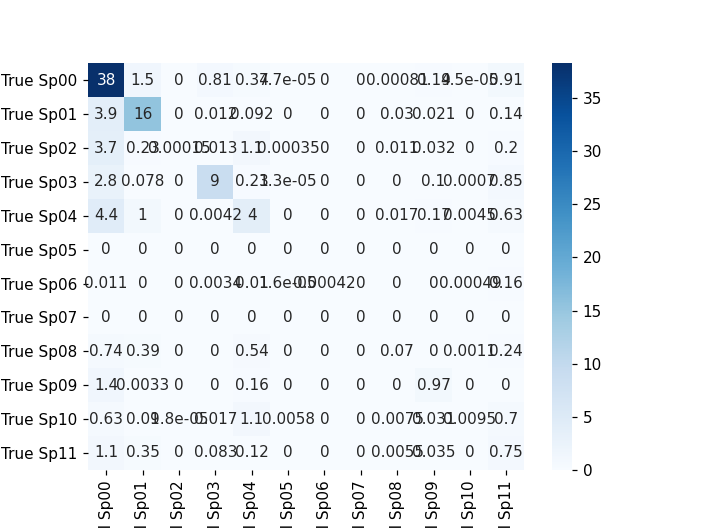

12 [ 0  1  2  3  4  5  6  8  9 10 11] [ 0  1  3  4  5  6  7  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


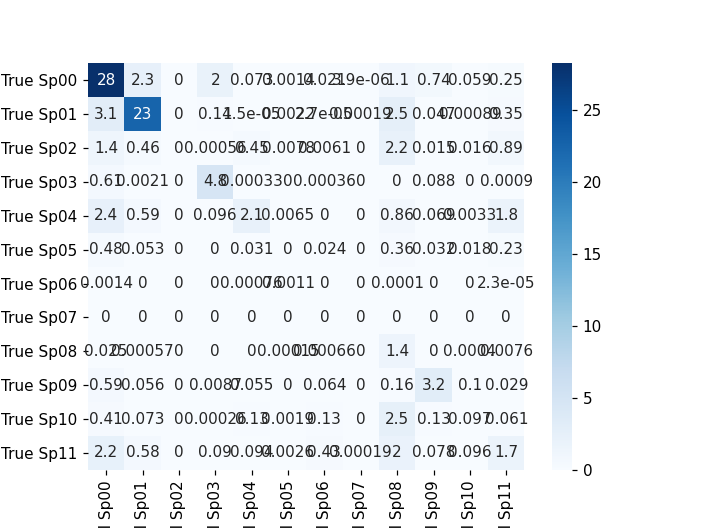

13 [ 0  1  2  3  4  5  8  9 10 11] [ 0  1  3  4  5  6  8  9 10 11] (12, 12)


<IPython.core.display.Javascript object>


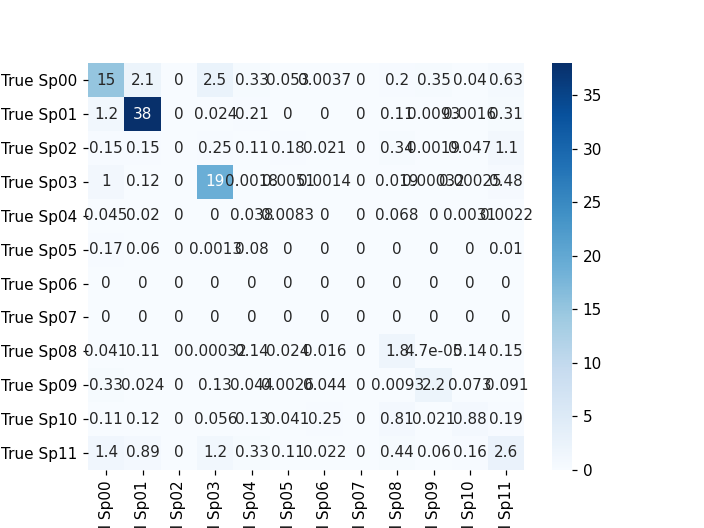

14 [0 2 5 6 7 8 9] [ 0  1  3  5  6  7  8 10] (12, 12)


<IPython.core.display.Javascript object>


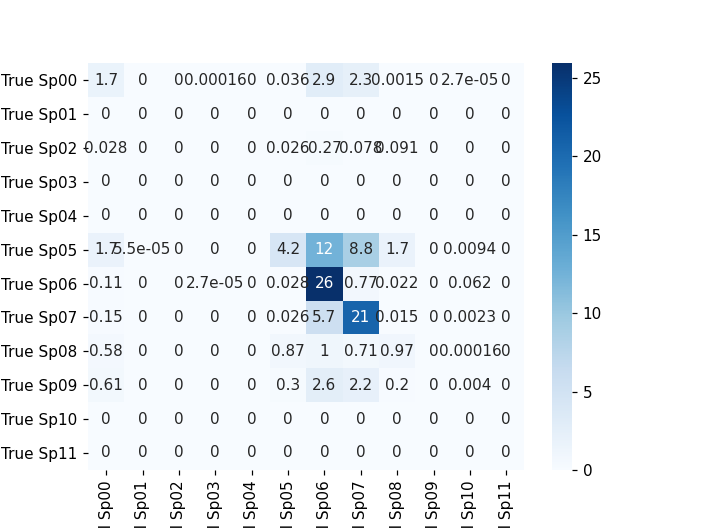

15 [ 0  1  2  3  5  6  7  8 10] [0 3 5 6 7] (12, 12)


<IPython.core.display.Javascript object>


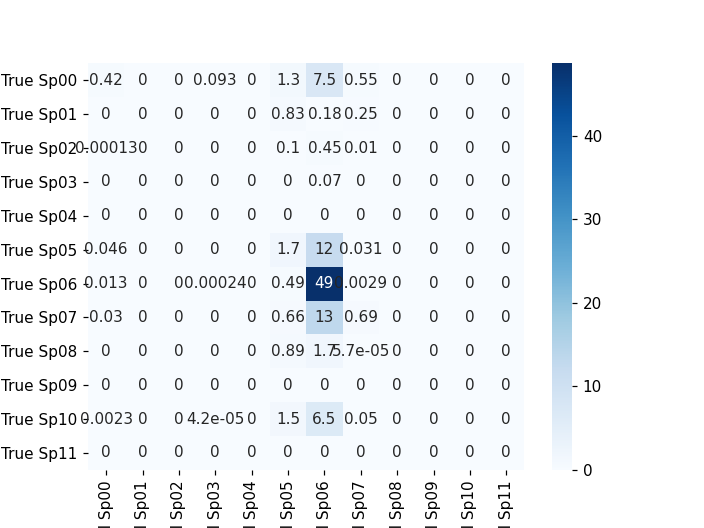

16 [0 3 5 6 7 8 9] [ 0  5  6  7 10] (12, 12)


<IPython.core.display.Javascript object>


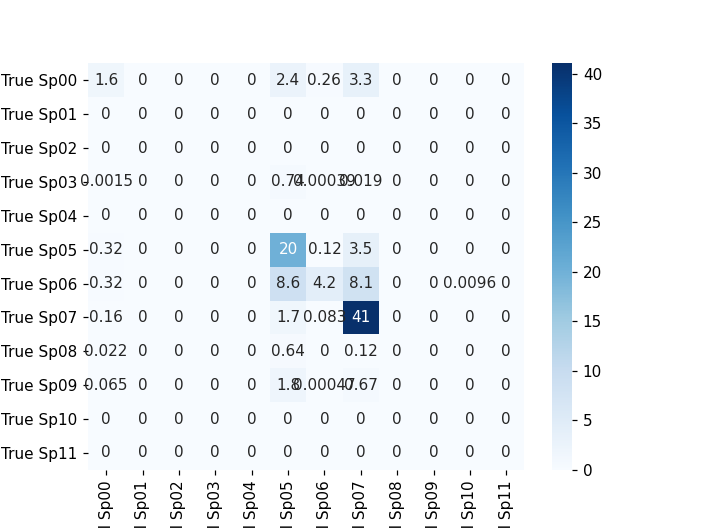

17 [ 0  5  6  7  8 10] [0 3 5 6 7] (12, 12)


<IPython.core.display.Javascript object>


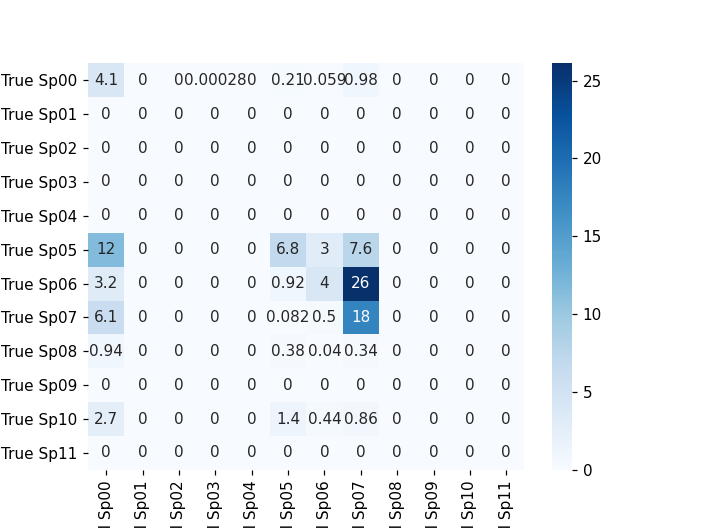

In [23]:
confusion_matrix_site = [np.zeros((len(all_labels), len(all_labels))) for i in range(1, len(sites) + 1)]

for i in range(1, len(sites) + 1):
    gt = cv2.imread(os.path.join(path, 'S{:d}GT.png'.format(i)), cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(os.path.join(path, 'S{:d}Result.png'.format(i)), cv2.IMREAD_GRAYSCALE)
    roi = cv2.imread(os.path.join(path, 'S{:d}ROI.png'.format(i)), cv2.IMREAD_GRAYSCALE) < 100

    gt_vec = gt[roi]
    pred_vec = pred[roi]
       
    print(i, np.unique(gt_vec), np.unique(pred_vec), confusion_matrix.shape)
    
    for lab_gt, lab_pred in zip(gt_vec, pred_vec):
        confusion_matrix_site[i - 1][lab_gt, lab_pred] += 100 / len(gt_vec)
    df_site = pd.DataFrame(
        confusion_matrix_site[i -1], index = ['True Sp{:02d}'.format(k) for k in range(0, 12)],
        columns = ['Model Sp{:02d}'.format(k) for k in range(0, 12)]
    )
    plt.figure()
    sn.heatmap(df_site, annot=True, cmap='Blues')

<IPython.core.display.Javascript object>


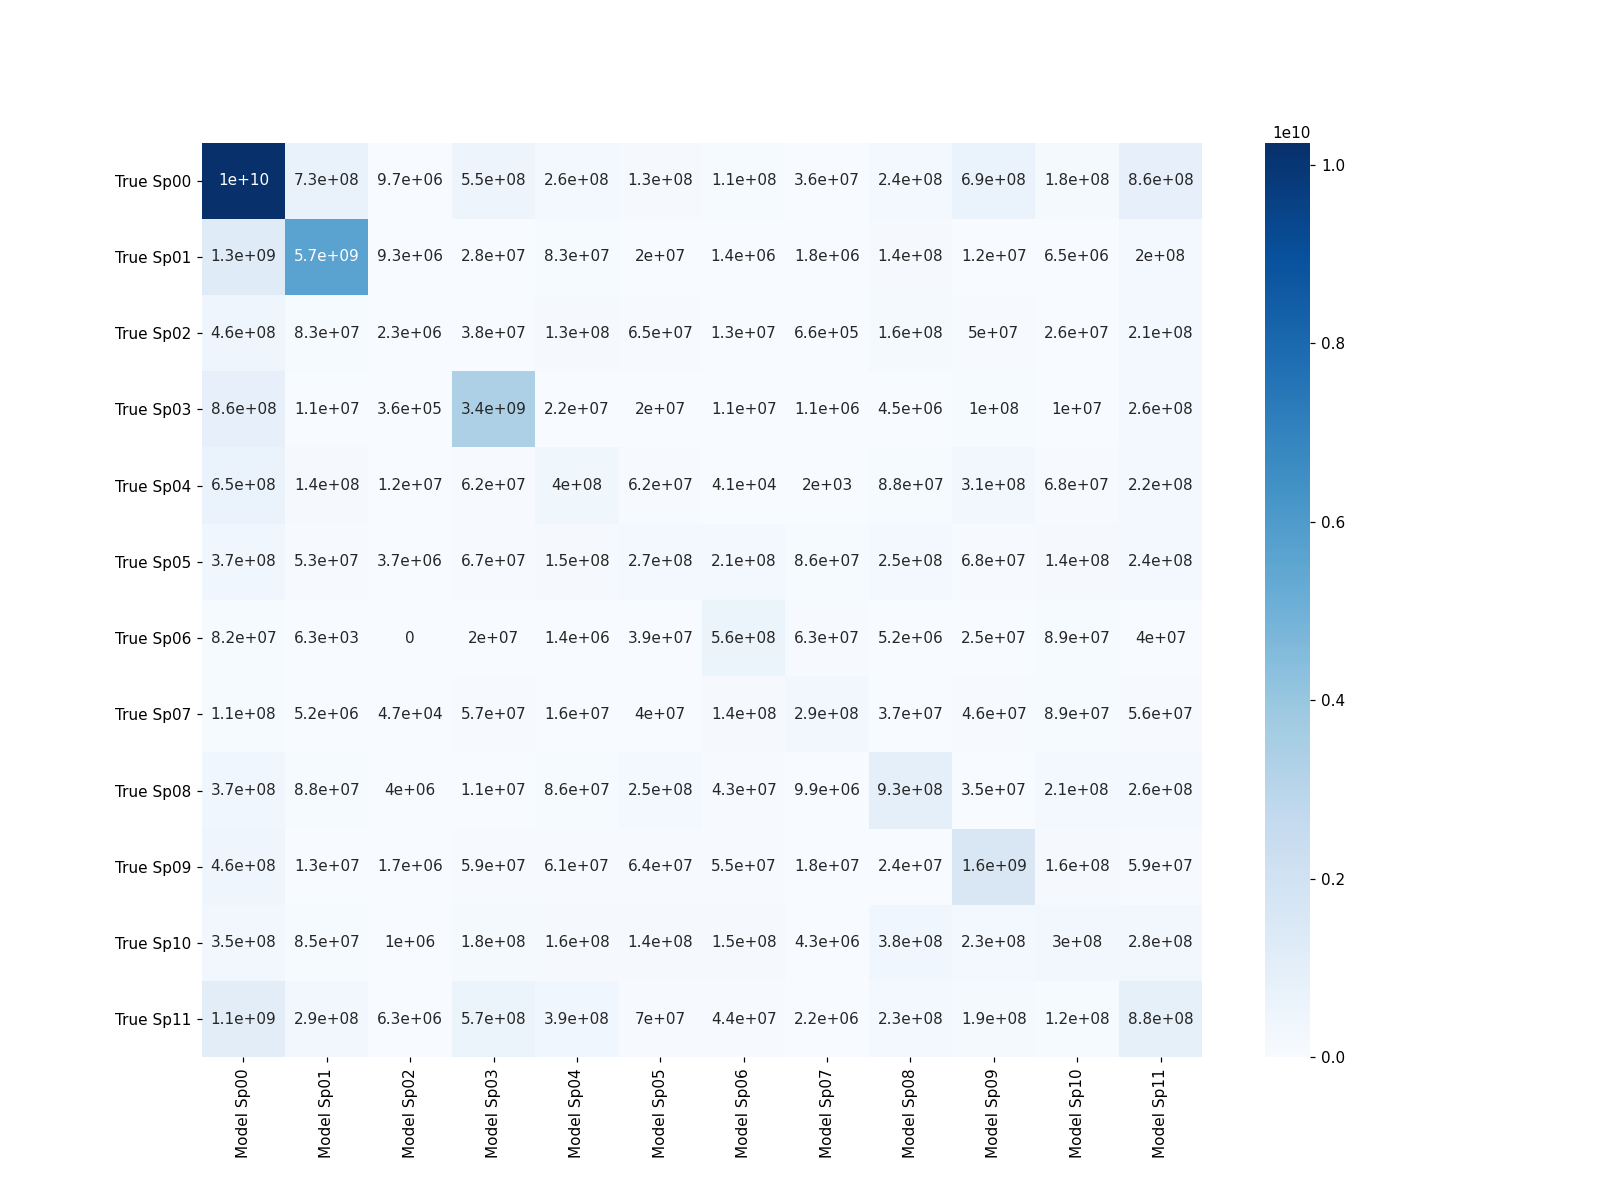

<AxesSubplot:>

In [28]:
confusion_matrix_all = np.zeros((len(all_labels), len(all_labels)))
for i in range(len(sites)):
    roi = cv2.imread(os.path.join(path, 'S{:d}ROI.png'.format(i + 1)), cv2.IMREAD_GRAYSCALE) < 100
    confusion_matrix_all += confusion_matrix_site[i] * np.sum(roi)
df_all = pd.DataFrame(
    confusion_matrix_all, index = ['True Sp{:02d}'.format(k) for k in range(0, 12)],
    columns = ['Model Sp{:02d}'.format(k) for k in range(0, 12)]
)
plt.figure()
sn.heatmap(df_all, annot=True, cmap='Blues')

<IPython.core.display.Javascript object>


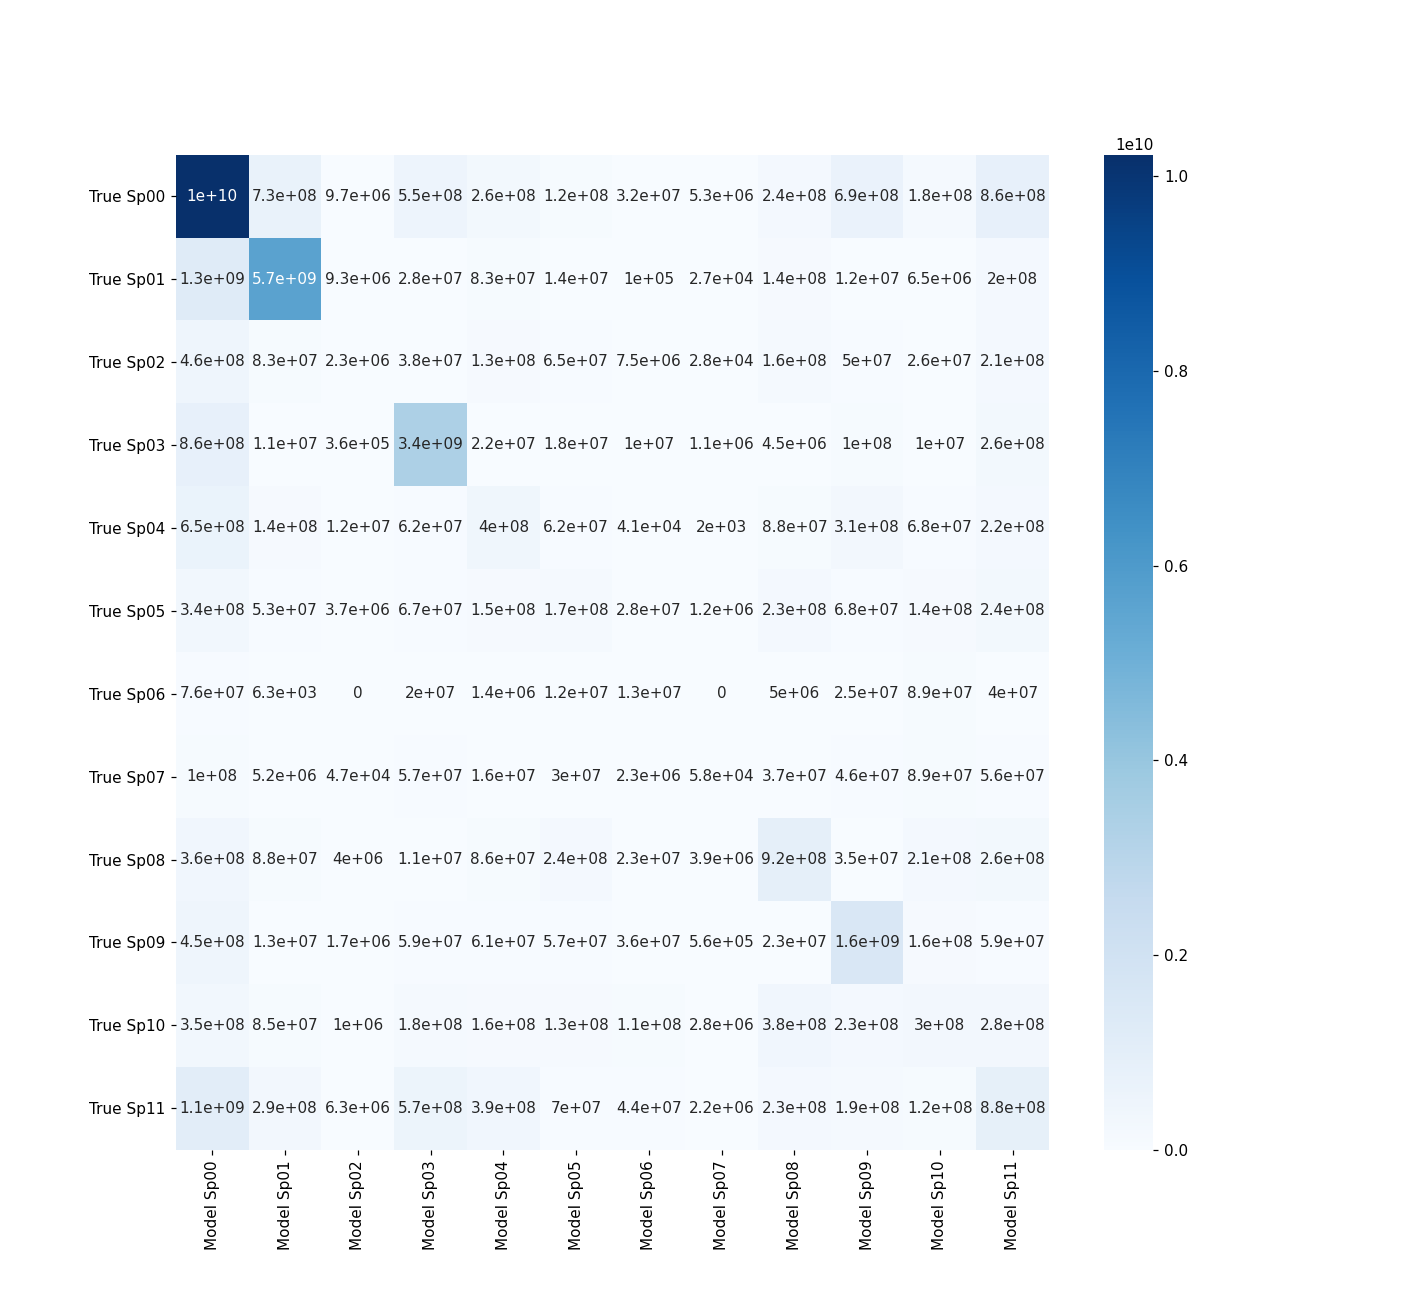

<AxesSubplot:>

In [31]:
confusion_matrix_sarah = np.zeros((len(all_labels), len(all_labels)))
for i in range(1, 14):
    roi = cv2.imread(os.path.join(path, 'S{:d}ROI.png'.format(i)), cv2.IMREAD_GRAYSCALE) < 100
    confusion_matrix_sarah += confusion_matrix_site[i - 1] * np.sum(roi)
df_sarah = pd.DataFrame(
    confusion_matrix_sarah, index = ['True Sp{:02d}'.format(k) for k in range(0, 12)],
    columns = ['Model Sp{:02d}'.format(k) for k in range(0, 12)]
)
plt.figure()
sn.heatmap(df_sarah, annot=True, cmap='Blues')

<IPython.core.display.Javascript object>


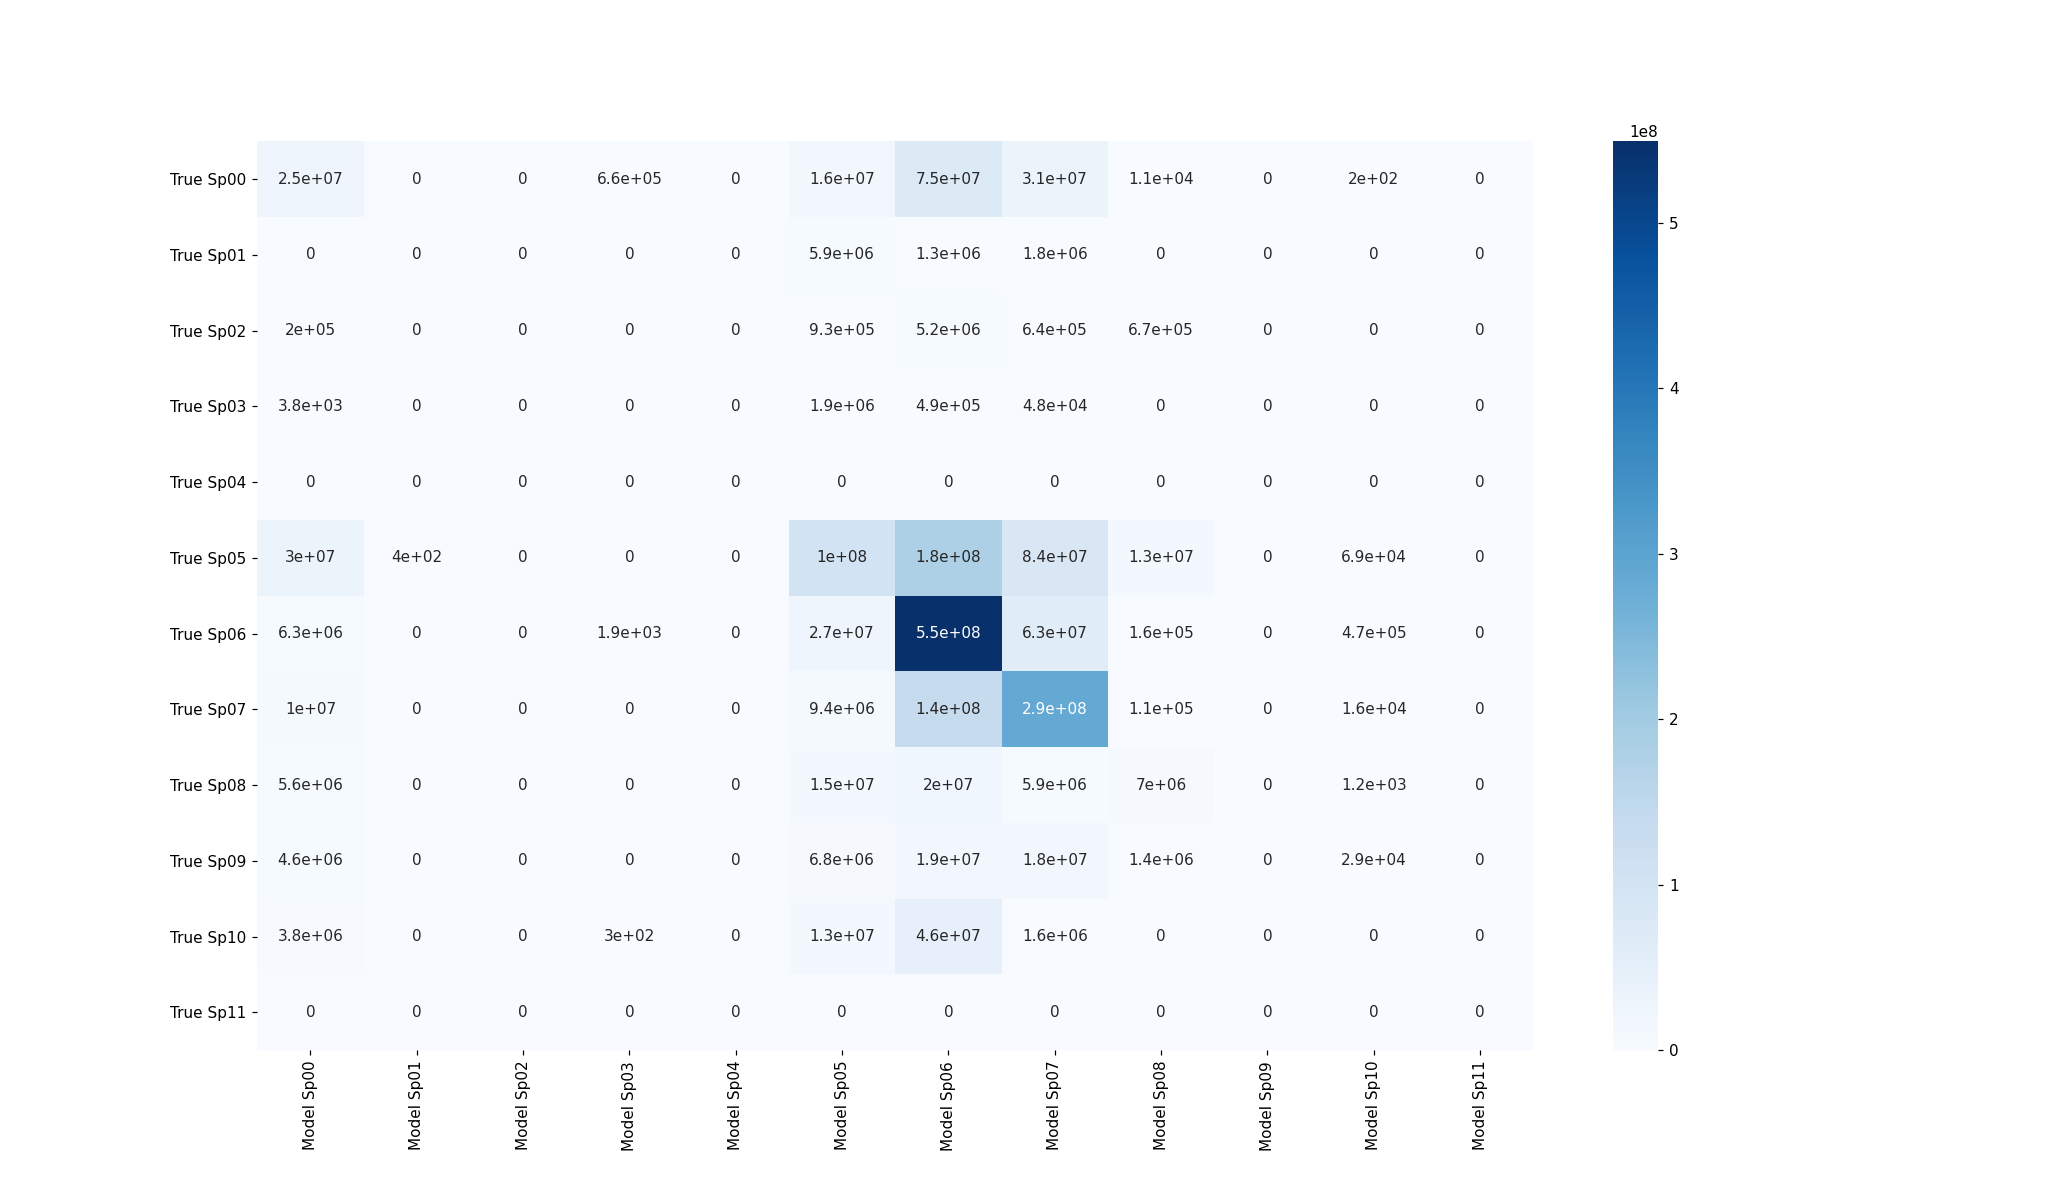

<AxesSubplot:>

In [32]:
confusion_matrix_luca = np.zeros((len(all_labels), len(all_labels)))
for i in range(14, len(sites) + 1):
    roi = cv2.imread(os.path.join(path, 'S{:d}ROI.png'.format(i)), cv2.IMREAD_GRAYSCALE) < 100
    confusion_matrix_luca += confusion_matrix_site[i - 1] * np.sum(roi)
df_luca = pd.DataFrame(
    confusion_matrix_luca, index = ['True Sp{:02d}'.format(k) for k in range(0, 12)],
    columns = ['Model Sp{:02d}'.format(k) for k in range(0, 12)]
)
plt.figure()
sn.heatmap(df_luca, annot=True, cmap='Blues')